# Recurrent artificial neural networks
# Long Short-Term Memory - LSTM
--------

This notebook will guide you through the training and testing of a LSTM network in the task of predicting the speed of a runner for a given slope by using her/his previous speeds during a given race.

Before running the cells in this notebook you have to upload some files with data from some races and the Python module for parsing those files and preparing a dataset.
### left panel -> Files -> Upload
Then select the compressed folder **strava.zip** and the Python module **strava.py**

### OR
Uncomment and update the code in the following cell if your data is in your google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp 'drive/My Drive/Colab Notebooks/strava.zip' .
#!cp 'drive/My Drive/Colab Notebooks/strava.py' .

Let us start by loading some Python modules

In [1]:
import numpy as np
from matplotlib import pyplot as pl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import strava as st

Then, let us unzip the compressed file you uploaded

In [2]:
if os.path.exists('strava'):
  print('Data are already in folder')
else:
  if os.path.exists('strava.zip'):
    !unzip strava.zip
  else:
    print('You must upload the data first!')

Data are already in folder


Declare some constants

In [3]:
PATH_DATA = 'strava'

FEATURES = ['time', 'speed', 'slope']    # selected from ['time', 'elevation', 'distance', 'speed', 'slope']
SPEED_OUTLIER = 8.0                      # speed > 30km/h
SLOPE_OUTLIER = 80                       # slope > +-80%
TIME_PERIOD = 1*60                       # period of time to average
SEGMENT_LENGTH = 100                     # length of the segment to average data
AVERAGE_SPEED_TH = 2.4                   # threshold to further clean the dataset

### Read the data
Parse the files in the **strava** folder

In [4]:
importer = st.RunImport(SPEED_OUTLIER, SLOPE_OUTLIER, TIME_PERIOD, SEGMENT_LENGTH, AVERAGE_SPEED_TH)
dataset = importer.import_path(PATH_DATA)

processing 20111004-161158-Run.tab
processing 20111008-153459-Run.tab
processing 20111012-153536-Run.tab
processing 20111015-065702-Run.tab
processing 20111018-163550-Run.tab
processing 20111023-082331-Run.tab
processing 20111027-091112-Run.tab
processing 20111030-100105-Run.tab
processing 20111105-081419-Run.tab
processing 20111108-164522-Run.tab
processing 20111112-171845-Run.tab
processing 20111115-172413-Run.tab
processing 20111122-172943-Run.tab
processing 20111130-172424-Run.tab
processing 20120225-155807-Run.tab
processing 20120310-170401-Run.tab
processing 20120325-092413-Run.tab
processing 20120327-162659-Run.tab
processing 20120403-161908-Run.tab
processing 20120414-082043-Run.tab
processing 20120420-143536-Run.tab
processing 20120422-134215-Run.tab
processing 20120428-150615-Run.tab
processing 20120508-154642-Run.tab
processing 20120515-154642-Run.tab
processing 20120521-161930-Run.tab
processing 20120528-095854-Run.tab
processing 20120605-154032-Run.tab
processing 20120618-

,time,elevation,distance,speed,slope,race
count,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000,20668.000000
mean,1854.441504,771.486180,5455.456205,3.043774,0.000594,129.087527
std,1433.385657,179.491611,4154.601351,0.398492,5.166486,64.712407
min,0.000000,6.170000,0.000000,0.000000,-23.195081,0.000000
25%,781.000000,755.680000,2292.405653,2.813920,-3.156888,79.000000
50%,1548.000000,798.381667,4587.222821,3.065299,-0.011887,137.000000
75%,2551.000000,830.025893,7594.768761,3.295895,3.117112,185.000000
max,7610.000000,2563.000000,21267.295568,7.864821,27.562581,229.000000



Dataset sample:


,time,elevation,distance,speed,slope,race
0,32,811.816667,95.126489,2.658523,2.323454,0
1,65,815.572727,194.508249,2.987546,0.284990,0
2,108,816.700000,297.413093,2.381489,2.072317,0
3,140,820.100000,390.282497,2.982812,3.596742,0
4,174,823.708333,491.585981,3.101678,3.520577,0
20663,5863,756.760000,17592.680098,3.179558,-0.951477,229
20664,5890,755.425000,17680.689783,3.265331,-2.887976,229
20665,5923,752.040000,17787.512109,3.246053,-2.813140,229
20666,5954,748.520000,17896.880646,3.535903,-2.771780,229
20667,5978,747.483333,17969.341362,2.773699,-3.384729,229


### Example of a race
The following cell shows an example of the data from a race

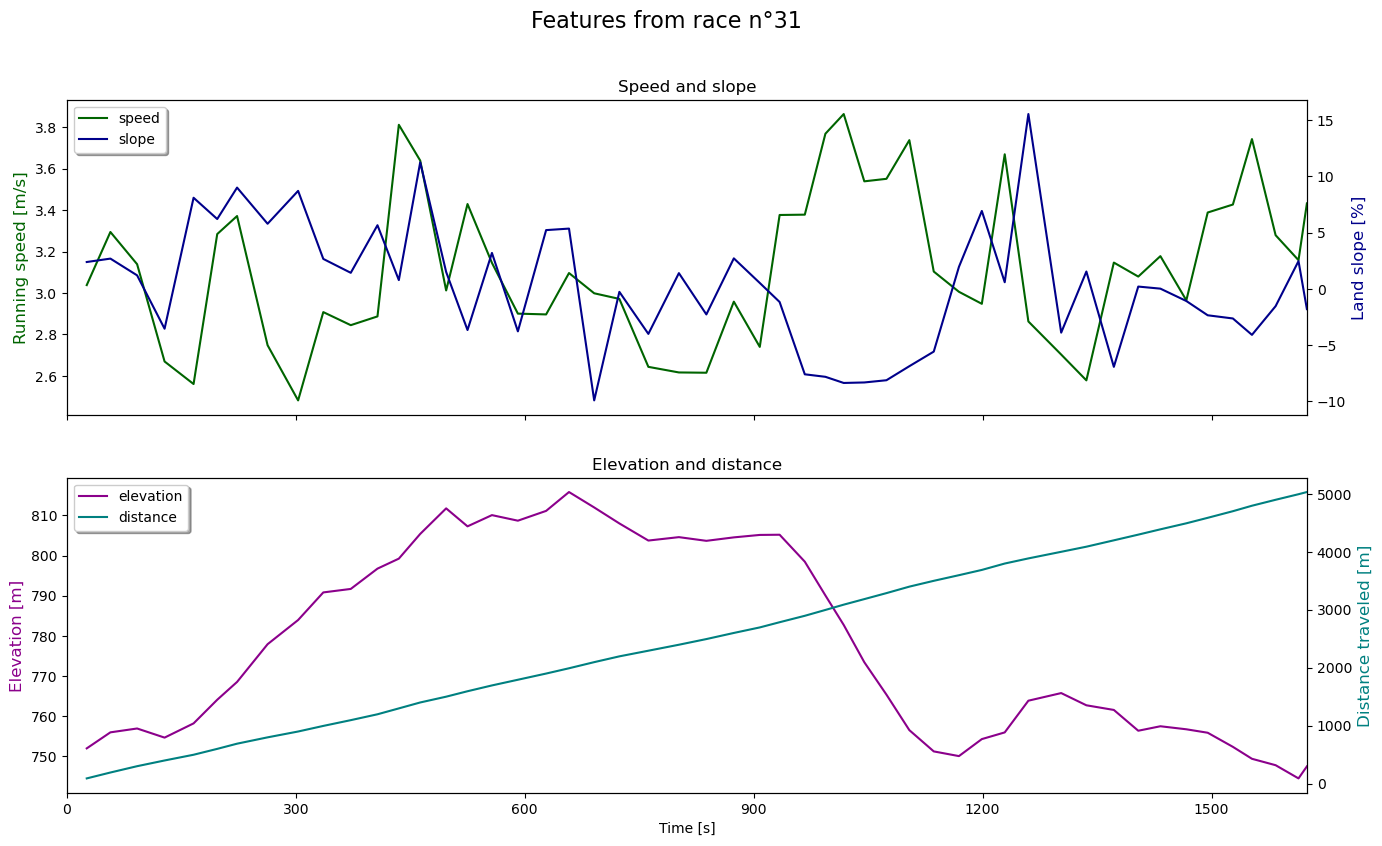

In [5]:
st.plot_race(dataset, np.random.randint(dataset['race'].max()))

### Normalize the dataset
The following cell normalizes the features into the interval [0, 1]

In [6]:
# Copy the dataset before normalisation, feature selection, numpy conversion, etc.
original_dataset = dataset.copy(deep=True)
min_speed = original_dataset['speed'].min()
max_speed = original_dataset['speed'].max()

#normalize only the selected features
#transform to numpy
normalized_dataset = dataset.filter(items=FEATURES).values
scaler = MinMaxScaler()
scaler.fit(normalized_dataset)
normalized_dataset = scaler.transform(normalized_dataset)
#transform back to dataframe
normalized_dataset = pd.DataFrame(normalized_dataset, index=dataset.index, columns=FEATURES)

#update the dataset with the new values
dataset.update(normalized_dataset)

print("Min (per features):", scaler.data_min_)
print("Max (per features):", scaler.data_max_)
display(dataset.head())

Min (per features): [  0.           0.         -23.19508109]
Max (per features): [7610.            7.86482054   27.56258073]


C:\Users\evara\AppData\Local\Temp\ipykernel_10276\765495803.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00420499 0.00854139 0.01419185 ... 0.778318   0.78239159 0.78554534]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.update(normalized_dataset)


,time,elevation,distance,speed,slope,race
0,0.004205,811.816667,95.126489,0.338027,0.502752,0
1,0.008541,815.572727,194.508249,0.379862,0.462592,0
2,0.014192,816.700000,297.413093,0.302803,0.497805,0
3,0.018397,820.100000,390.282497,0.379260,0.527838,0
4,0.022865,823.708333,491.585981,0.394374,0.526337,0


### Create a training and a testing subset
Split the dataset into training and testing


In [142]:
TIMESTEPS = 20                   #define sequence length
TEST_SIZE = 0.2                  #value between ]0;1[
TRAINING_SIZE = 1 - TEST_SIZE

In [143]:
all_races = np.unique(dataset['race'])
print('Number of races', len(all_races))
RACES_TRAINING = int(np.floor(TRAINING_SIZE * len(all_races)))
races_train = np.random.choice(all_races, RACES_TRAINING, replace=False)
# print(races_train)
races_test = list(set(all_races) - set(races_train))
# print(races_test)
print(len(races_train), 'used during training --- Number of samples', np.sum(np.isin(dataset['race'], races_train)))
print(len(races_test), 'used during test\t --- Number of samples', np.sum(np.isin(dataset['race'], races_test)))

Number of races 230
184 used during training --- Number of samples 16322
46 used during test	 --- Number of samples 4346


### Create inputs and outputs
The folowing cell contains the function that will be used to create the inputs and outputs for training the models

In [144]:
#take a dataframe as input and return the splitted version with the prediction as a numpy array
def create_x_y(data, races):
  speed_index = data[FEATURES].columns.get_loc('speed') #get speed index
  slope_index = data[FEATURES].columns.get_loc('slope') #get slope index
  time_index = data[FEATURES].columns.get_loc('time') #get time index
  x = None
  y = None

  #iterate over every race
  for r in races:
    #filter race
    race_df = data.loc[data['race'] == r]
    #filter features
    race_np = race_df[FEATURES].values
    #split into timesteps (timesteps + 1 to take the target value)
    race_np = [race_np[i:(i+TIMESTEPS+1)] for i in range(race_np.shape[0] - (TIMESTEPS+2))]

    if len(race_np) == 0:
      print("Warning: not enough values in race", r)
      continue

    race_np = np.stack(race_np, axis=0)

    temp_x = np.dstack([race_np[:,1:,time_index],       # last TIMESTEPS-1 times and next time
                       race_np[:,1:,slope_index],       # last TIMESTEPS-1 slopes and next slope
                       race_np[:,:-1,speed_index]])     # last TIMESTEPS speeds
    temp_y = race_np[:,-1, speed_index]                 # next speed

    if x is None:
      x = temp_x
      y = temp_y
    else:
      x = np.append(x, temp_x, axis=0)
      y = np.append(y, temp_y, axis=0)

  return x, y

In [145]:
print('original shape:', dataset.shape)

X_train, y_train = create_x_y(dataset, races_train)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_test, y_test = create_x_y(dataset, races_test)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


original shape: (20668, 6)
X_train shape: (12274, 20, 3)
y_train shape: (12274,)
X_test shape: (3334, 20, 3)
y_test shape: (3334,)


### Create a model and train it
The following cells create a LSTM network and train it with the training subset

In [147]:
BATCH_SIZE = 64          # Size of the batch for training
NB_EPOCHS = 30    # Number of times the training dataset is presented
NB_UNITS = 1         # Number of LSTM units

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(NB_UNITS, input_shape=(TIMESTEPS, len(FEATURES))))
#dense layer 1 : connect all LSTM cell to one cell -> output shape as (*, 1)
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 1)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [125]:
history = model.fit(X_train, y_train, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_test, y_test))

Epoch 1/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0150 - val_loss: 0.0021
Epoch 2/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/st

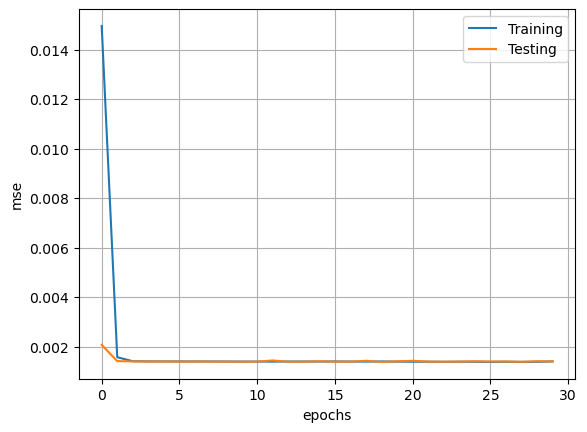

In [126]:
# Plot the training and testing
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.xlabel('epochs')
pl.ylabel('mse')
pl.legend()
pl.grid()

### Evaluate the performance of the model
The following cell computes the correlation between the actual speed of the runner and the model's output

In [127]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('Training correlation coefficient:', np.corrcoef(y_train.T, y_train_pred.T)[0,1])
print('Test correlation coefficient:', np.corrcoef(y_test.T, y_test_pred.T)[0,1])

486/486 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training correlation coefficient: 0.6356890957538617
Test correlation coefficient: 0.6451543011669923


### Visualize the results
The following cell visualize the output of the LSTM for a single race in the testing subset and compare it with the actual speed of the runner

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


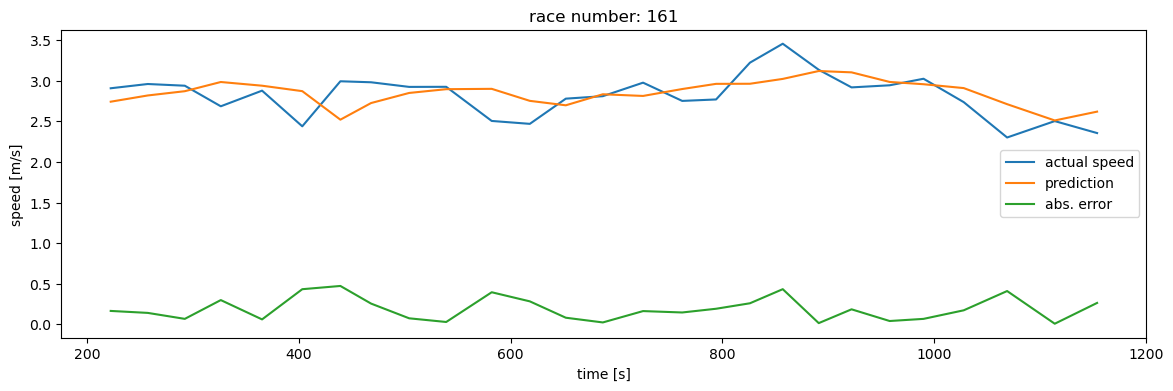

In [139]:
random_race = np.random.choice(races_test)
X, y = create_x_y(dataset, [random_race])
X_o, y_o = create_x_y(original_dataset, [random_race])            # select inputs and output from the unnormalized dataset also

y_pred_o = model.predict(X) * (max_speed - min_speed) + min_speed # unnormalize the prediction

pl.figure(figsize=(14,4))
pl.plot(X_o[:,-1,0], y_o, label='actual speed')
pl.plot(X_o[:,-1,0], y_pred_o, label='prediction')
pl.plot(X_o[:,-1,0], np.abs(y_o - y_pred_o[:,0]), label='abs. error')
pl.legend()
pl.title('race number: ' + str(random_race))
pl.xlabel('time [s]')
pl.ylabel('speed [m/s]');


# Exercise

1. Change the number of units and epochs of the LSTM network. Show the configuration that performed the best.
2. What is the largest error (speed prediction) you observed? Do you observe that most of those large errors show up for high speeds ? or low speeds? Why?
3. Using the predicted speeds for a given race, compute the expected time for a race and compute the difference between the real race time and the predicted race time in minutes. Provide the code of the cell that computes this prediction error.